In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
main_df = pd.read_csv('../data/World Energy Consumption.csv')
main_df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
2,ASEAN (Ember),2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
3,ASEAN (Ember),2003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
4,ASEAN (Ember),2004,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN


In [3]:
countries = ['New Zealand', 'Canada', 'Australia', 'United Kingdom', 'United States']
filtered_df = main_df[main_df['country'].isin(countries)]
filtered_df

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
1512,Australia,1900,AUS,3693331.0,2.393118e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1513,Australia,1901,AUS,3755013.0,2.322160e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1514,Australia,1902,AUS,3815541.0,2.346190e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1515,Australia,1903,AUS,3874858.0,2.531231e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1516,Australia,1904,AUS,3935097.0,2.701432e+10,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20706,United States,2018,USA,332140032.0,1.814065e+13,-1.325,-5.433,1218.223,404.621,186.156,...,2.222,0.932,7.222,45.081,728.691,820.949,272.67,2193.926,6.490,2.723
20707,United States,2019,USA,334319680.0,NaN,2.780,11.250,1243.930,415.870,172.021,...,2.570,1.071,8.514,59.126,787.816,885.021,295.88,2356.476,7.115,2.965
20708,United States,2020,USA,335942016.0,NaN,-9.029,-37.549,1126.150,378.321,162.826,...,3.233,1.409,14.214,108.672,896.488,1005.947,337.94,2668.579,8.358,3.644
20709,United States,2021,USA,336997632.0,NaN,9.917,37.518,1233.954,415.839,160.980,...,3.958,1.675,11.913,103.127,999.615,1122.263,378.20,2966.237,9.105,3.853


In [4]:
columns_needed = ['country', 'year', 'greenhouse_gas_emissions']
data_selected = filtered_df[columns_needed]

# Check for missing values in the selected columns
data_selected.isnull().sum()

country                       0
year                          0
greenhouse_gas_emissions    500
dtype: int64

In [5]:
# Drop rows with missing values
data_selected = data_selected.dropna()
data_selected.isnull().sum()

country                     0
year                        0
greenhouse_gas_emissions    0
dtype: int64

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\WINDOWS\AppData\Local\Programs\Pytho

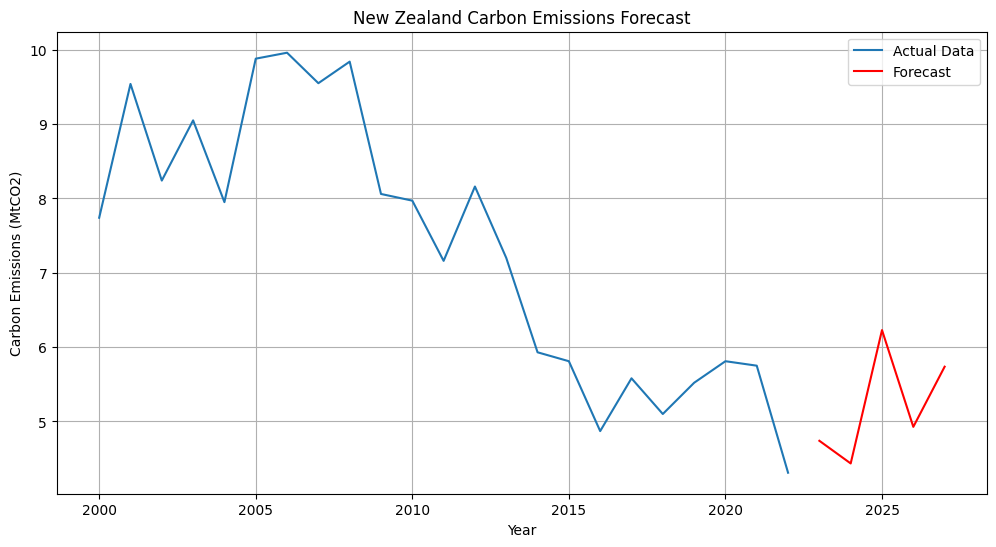

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sari

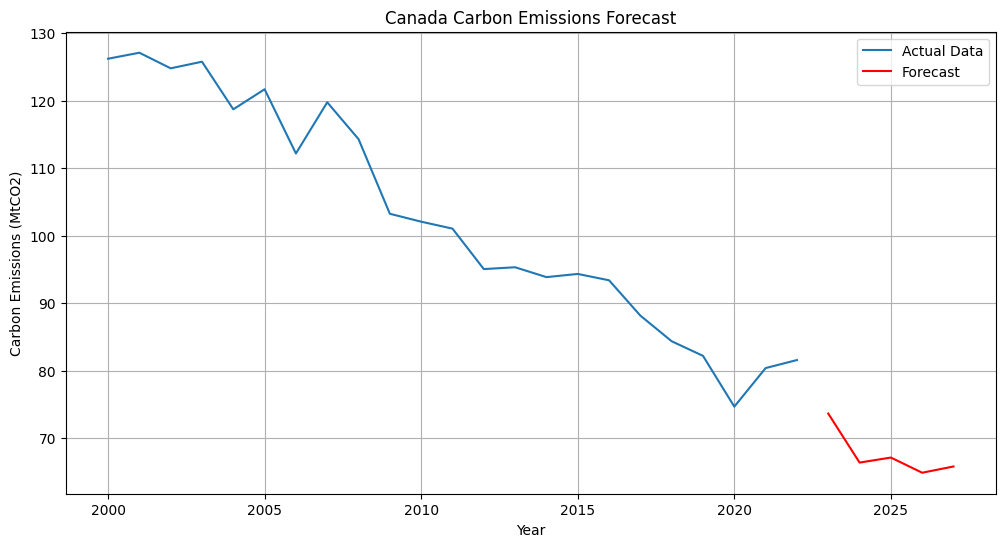

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\WINDOWS\AppData\Local\Programs\Pytho

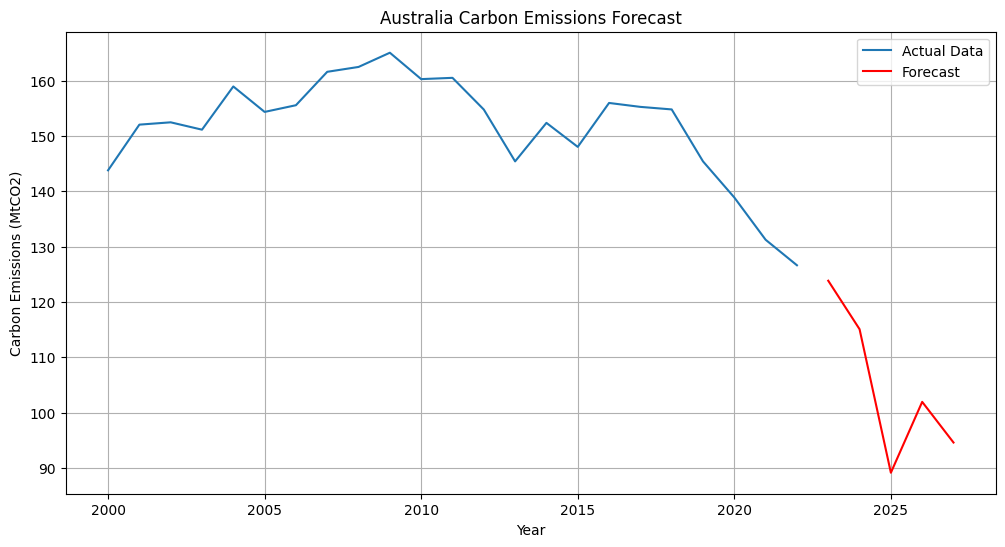

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\WINDOWS\AppData\Local\Programs\Pytho

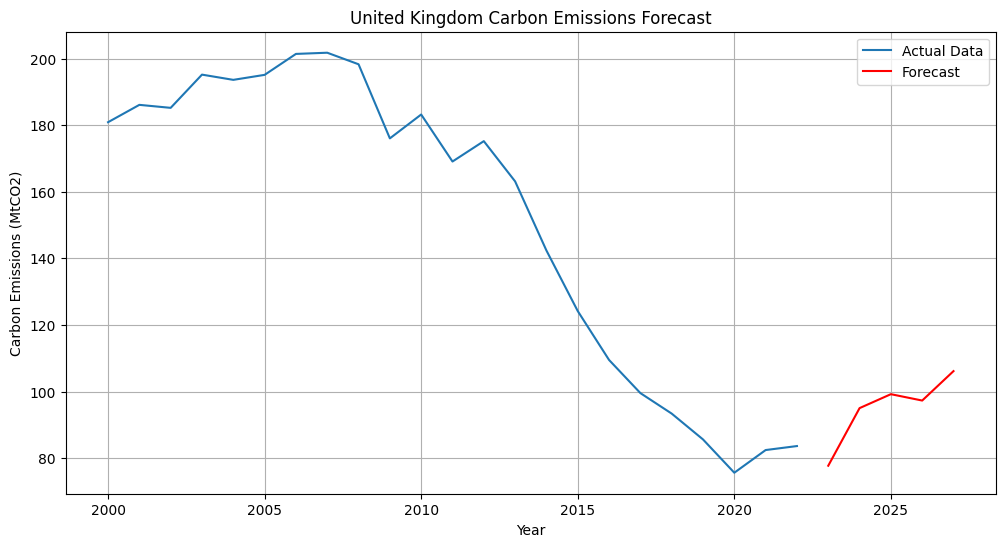

c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\WINDOWS\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\ts

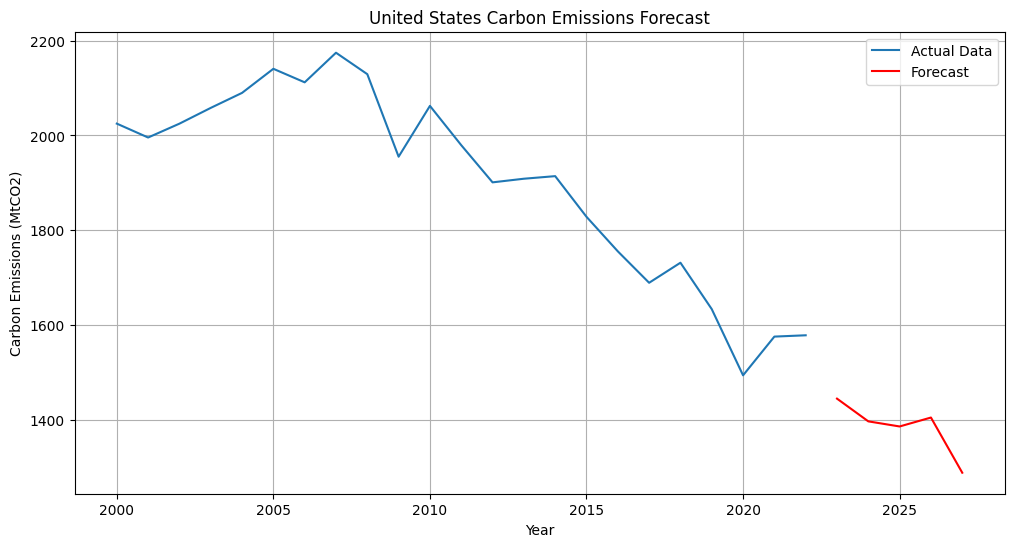

In [6]:
# Carban emissions forcasting
def forecast_carban_emissions(country, years_to_forecast=5):
    country_data = data_selected[data_selected['country'] == country]
    country_data = country_data.set_index('year')
    series = country_data['greenhouse_gas_emissions'].dropna()

    if series.empty:
        print(f"No data available for {country} to forecast carbon emissions.")
        return None
    
    model = SARIMAX(series, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=years_to_forecast)

    forecasting_years_range = np.arange(country_data.index[-1] + 1, country_data.index[-1] + years_to_forecast + 1)

    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series.values, label='Actual Data')
    plt.plot(forecasting_years_range, forecast.values, label='Forecast', color='red')
    plt.title(f'{country} Carbon Emissions Forecast')
    plt.xlabel('Year')
    plt.ylabel('Carbon Emissions (MtCO2)')
    plt.legend()
    plt.grid(True)
    plt.show()

    return forecast

for country in countries:
    forecast_carban_emissions(country, years_to_forecast=5)